Note: Use this template to develop your project. Do not change the steps. For each step, you may add additional cells if needed.

#### Import Libraries

In [1]:
%matplotlib notebook
%config Completer.use_jedi=False
import warnings

import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

#### Load the dataset

In [2]:
#read the data into a Pandas Dataframe object
df = pd.read_csv('classification_dataset.csv')

In [3]:
#return the first 5 rows of data
df.head()

,f1,f2,f3,f4,f5,label
0,1.286233,15.643743,-1.879915,-11.294839,15.245472,0
1,2.853398,0.129878,17.620669,3.945204,8.157459,1
2,3.285310,3.176560,12.610554,-6.063613,1.831887,0
3,2.019516,-1.967793,9.306435,-0.938714,-1.203038,0
4,-2.326527,3.453234,13.855478,-5.236421,1.547216,0


In [4]:
#return the value count for label 1 and 0
df['label'].value_counts()

0    500
1    500
Name: label, dtype: int64

#### Define the loss function

In [5]:
def loss_fn(y,y_pred):
    """ 
    This function calculates the loss function. We use binary cross entropy for classification dataset.
    """
    loss= -tf.reduce_mean(y* tf.math.log(y_pred) + (1 - y) * tf.math.log(1 - y_pred))
    return loss

#### Define function to perform prediction

In [6]:
def sigmoid(x):
    """ 
    This function calculates the sigmoid function. We implement sigmoid function to transform the
    real value of prediction a range of (0,1).
    """
    return 1/(1 + tf.exp(-x))

def relu(x):
    """ 
    This function calculates the ReLU function. We implement ReLu as activation function that will return 0 
    for any negative value and if it is a positive value, it will return the value itself. 
    """
    return tf.maximum(0, x)

def forward(X, w1, b1, w2, b2):
    """ 
    This function calculates the forward pass (predicts the label). 
    The forward function takes the input data(X), weights(w1 and w2) and biases (b1 and b2). 
    To get the output layer probability we use the sigmoid function. 
    """
    hidden_layer_input= tf.add(tf.matmul(X, w1), b1)
    #print(hidden_layer_input)
    hidden_layer_output = tf.nn.relu(hidden_layer_input)
     #print(output_layer)
    output_layer = tf.add(tf.matmul(hidden_layer_output, w2), b2)
    output_layer_probability=tf.nn.sigmoid(output_layer)
    #print(output_layer_probability)
    return output_layer_probability


#### Define function for model training
Display the training and validation loss values for each epoch of the training loop. The displayed value must be in 6 decimal places.<br>
Hint: <br>
Use `tf.GradientTape` to compute the gradients.

In [7]:
def train(X_train, y_train, w1, b1, w2, b2, learning_rate,batch_size):
    """ 
    This function performs the forward pass, computes the gradient and update the weights and biases.
    We train the model using mini batch gradient descent. It will splitting the data into smaller subsets 
    and calculate the gradient descent for each batch. Then update the weight and biases which are the model parameters. 
    """
    num_batches = len(X_train)//batch_size
    for batch in range(num_batches):
        start = batch * batch_size
        end = (batch + 1) * batch_size
        with tf.GradientTape() as tape:
            predictions = forward(X_train, w1, b1, w2, b2)
            current_loss = loss_fn(y_train, predictions)
        gradients = tape.gradient(current_loss, [w1, b1, w2, b2])
        w1.assign_sub(learning_rate * gradients[0])
        b1.assign_sub(learning_rate * gradients[1])
        w2.assign_sub(learning_rate * gradients[2])
        b2.assign_sub(learning_rate * gradients[3])
    return current_loss

    
def fit(X_train, y_train, X_val, y_val, epochs, learning_rate,batch_size,early_stopping_patience):
    """ 
    This function implements the training loop. 
    monitors the validation loss during training and stops the training process early if 
    there is no improvement in validation loss for a certain number of epochs.
    """
    best_val_loss = float('inf')  #we initialize best_val_loss as value positive infinity
    patience = early_stopping_patience
    train_loss_results = []
    val_loss_results = []
    
    for epoch in range(epochs):
        train_loss = train(X_train, y_train, w1, b1, w2, b2, learning_rate,batch_size)
        train_loss_results.append(train_loss)
        
        val_predictions = forward(X_val, w1, b1, w2, b2)
        val_loss = loss_fn(y_val, val_predictions)
        val_loss_results.append(val_loss)
        print(f"Epoch {epoch+1}/{epochs}: Training Loss: {train_loss.numpy():.6f}, Validation Loss: {val_loss.numpy():.6f}")
        if val_loss < best_val_loss: #if the current validation loss (val_loss) is less than the best validation loss observed so far (best_val_loss), it means 
            best_val_loss = val_loss #it will update indicating that the model has achieved new best validation loss
            patience = early_stopping_patience
        else:
            patience -= 1            #this happen if the model is not improved
            if patience == 0:        #This show that the model is not improved for certain number consecutive epochs (determine by early stopping patience)
                print("Early stopping...")
                break
    
    return w1, b1, w2, b2, train_loss_results, val_loss_results

#### Define the tensors to hold the weights and biases (create the model)
Hint: <br>
Use `tf.Variable` to create the tensors.<br>
Put the tensors in a list.

In [8]:
#define a function to create the model tensors
def create_model(input_size, num_hidden_units, output_size):
    # Initialize weights and biases for the first layer
    w1 = tf.Variable(tf.random.normal([input_size, num_hidden_units])) #weight tensor for the first layer
    b1 = tf.Variable(tf.zeros([num_hidden_units])) #bias tensor for the first layer
    w2 = tf.Variable(tf.random.normal([num_hidden_units, output_size])) #weight tensor for the second layer
    b2 = tf.Variable(tf.zeros([output_size])) #bias tensor for the first layer
    
    # Put the tensors in a list for easy access and management
    model_parameters = [w1, b1, w2, b2]
    
    return model_parameters

In [9]:
#Define input size, number of hidden  units and output size
input_size = 5
num_hidden_units = 32  # Define the number of units in the hidden layer
output_size= 1
#Create the model tensor using defined parameters
w1, b1, w2, b2 = create_model(input_size, num_hidden_units, output_size)

#### Split the dataset
The ratio of training and test is 7:1:2.

In [10]:
#x is features variable and y is target variable
y = df['label'] #assigning the 'label' column of DataFrame as target variable, y
X = df.drop(columns=['label']) #assigning all columns of DataFrame label as features variables, X

In [11]:
#Print the shapes of the features variables 'X' and the target variable 'y' to check the shapes of our data 
#to ensure that they are correctly loaded and formatted
print("Shape of X:", X.shape) 
print("Shape of y:", y.shape)

Shape of X: (1000, 5)
Shape of y: (1000,)


In [12]:
from sklearn.model_selection import train_test_split
seed_num = 0    #set a random seed for reproductibility
#split data into 70% as training data and 30% as temporary sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3,random_state=seed_num)
#futher splitting the temporary data into validation and testing sets, each with 1/3 of the temporary data
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp,test_size=1/3, random_state=seed_num)
print(X_train.shape)     #to print the shape of training features set
print(y_train.shape)     #to print the shape of training target set
print(X_val.shape)       #to print the shape of validation features set
print(y_val.shape)       #to print the shape of validation target set
print(X_test.shape)      #to print the shape of testing features set
print(y_test.shape)      #to print the shape of testing target set
print(w1.shape)

(700, 5)
(700,)
(100, 5)
(100,)
(200, 5)
(200,)
(5, 32)


In [13]:
#to count occurences of unique values in training target variable
y_train.value_counts()    

1    367
0    333
Name: label, dtype: int64

In [14]:
#to store the training target variable
y_train

105    1
68     0
479    0
399    0
434    1
      ..
835    0
192    0
629    1
559    0
684    0
Name: label, Length: 700, dtype: int64

In [15]:
#to count occurences of unique values in validation target variable
y_val.value_counts()

0    59
1    41
Name: label, dtype: int64

In [16]:
#to count occurences of unique values in testing target variable
y_test.value_counts()

0    108
1     92
Name: label, dtype: int64

#### Normalize the data

In [17]:
#step for preprocessing the data which will scale the features to specific range, between 0 and 1. 
#to work better with data that have similar scale
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)    #scale the training dataset
X_val = scaler.transform(X_val)            #scale the validation dataset
X_test = scaler.transform(X_test)          #scale the testing dataset

In [18]:
#Converting each dataset namely training, testing and validation datesets into TensorFlow tensors to build and training the neural network models.
X_train, y_train= tf.convert_to_tensor(X_train, dtype= tf.float32), tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test, y_test= tf.convert_to_tensor(X_test, dtype= tf.float32), tf.convert_to_tensor(y_test, dtype=tf.float32)
X_val, y_val= tf.convert_to_tensor(X_val, dtype= tf.float32), tf.convert_to_tensor(y_val, dtype=tf.float32)

#### Train the model using mini batch gradient descent and implement early stopping

In [19]:
#Define hyperparameters
epochs = 100                #number of training epochs
learning_rate = 0.01        #learning rate for gradient descent
batch_size=32               #batch size for mini-batch gradient descent 
early_stopping=5            #patience for early stopping 
#Train the model using fit() where the training, validation datasets and the define hyperparameter is passed
w1, b1, w2, b2, train_loss_results, val_loss_results = fit(X_train, y_train, X_val, y_val, epochs, learning_rate, batch_size,early_stopping)
#This function responsible to training the model using the training data and validating it using validation data
#The early stopping will determine when to stop the training if there is no improvement in the validation loss 

Epoch 1/100: Training Loss: 0.981262, Validation Loss: 1.072487
Epoch 2/100: Training Loss: 0.943688, Validation Loss: 1.006574
Epoch 3/100: Training Loss: 0.912860, Validation Loss: 0.964789
Epoch 4/100: Training Loss: 0.886142, Validation Loss: 0.930091
Epoch 5/100: Training Loss: 0.863312, Validation Loss: 0.900784
Epoch 6/100: Training Loss: 0.843936, Validation Loss: 0.875925
Epoch 7/100: Training Loss: 0.827343, Validation Loss: 0.854671
Epoch 8/100: Training Loss: 0.813049, Validation Loss: 0.836236
Epoch 9/100: Training Loss: 0.800721, Validation Loss: 0.820666
Epoch 10/100: Training Loss: 0.790056, Validation Loss: 0.807210
Epoch 11/100: Training Loss: 0.780734, Validation Loss: 0.795523
Epoch 12/100: Training Loss: 0.772610, Validation Loss: 0.785373
Epoch 13/100: Training Loss: 0.765469, Validation Loss: 0.776597
Epoch 14/100: Training Loss: 0.759151, Validation Loss: 0.768929
Epoch 15/100: Training Loss: 0.753519, Validation Loss: 0.762296
Epoch 16/100: Training Loss: 0.748

#### Display the training loss and validation loss against epoch graph

<IPython.core.display.Javascript object>


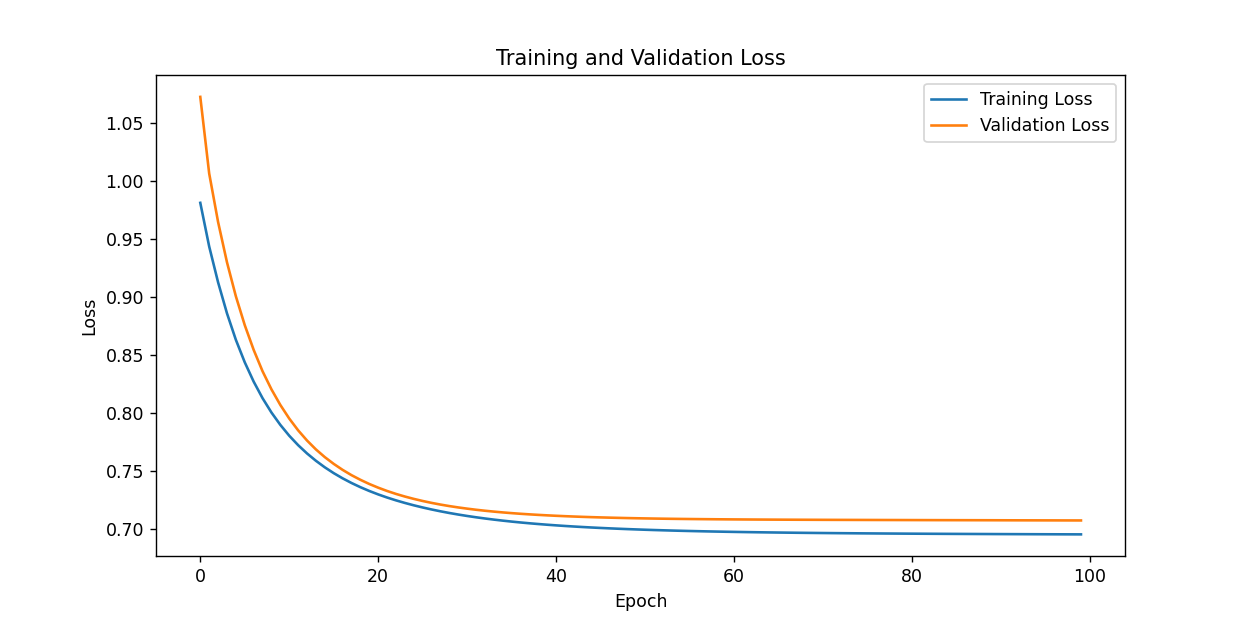

In [20]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))                                #to create the figure for displaying the graph
plt.plot(train_loss_results, label='Training Loss')        #plotting the train_loss_result which containing training loss value 
plt.plot(val_loss_results, label='Validation Loss')        #plotting the train_loss_result which containing validation loss value 
plt.xlabel('Epoch')                                        #x-axis represent of number of training epoch
plt.ylabel('Loss')                                         #y-axis represent of loss value
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

#### Predict the test set

In [21]:
# Evaluate the model on the test set
test_predictions = forward(X_test, w1, b1, w2, b2)

# Convert predictions to binary labels
test_predictions = tf.where(test_predictions > 0.5, 1.0, 0.0)
y_test_binary = tf.where(y_test > 0.5, 1.0, 0.0)

#### Display the confusion matrix and the classification report.

In [22]:
# Calculate confusion matrix and classification report
conf_matrix = confusion_matrix(y_test_binary, test_predictions)
class_report = classification_report(y_test_binary, test_predictions)

#to print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)
#to print the classification report
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[32 76]
 [27 65]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.54      0.30      0.38       108
         1.0       0.46      0.71      0.56        92

    accuracy                           0.48       200
   macro avg       0.50      0.50      0.47       200
weighted avg       0.50      0.48      0.46       200

